# Сравнение производительности алгоритма Борувки на GraphBLAS и Pregel+

### Описание вычислительной машины

- Процессор: 12th Gen Intel Core i7-12700H

- 14 ядер (без гипертрединга)

- RAM: 16 GB

- Операционная система: Linux Mint 21.3

Используемое ПО:

- GCC 11.4.0

- openjdk 8

- hadoop 2.6.1

- MPICH 3.1

### Описание эксперемента

**Целью эксперимента** является сравнение средней работы реализации выбранного алгоритма.

**Ход эксперимента:**
- Сделать 30 запусков алгоритмов
- Составить информацию о среднем и дисперсии
- Построить доверительные интервалы
- Провести анализ результатов

**Гипотезы:**
- Среднее время работы алгоритма Борувки на GraphBLAS будет меньше, чем на Pregel+, для данного набора графов
- Pregel+ будет существенную часть времени тратить на передачу сообщений в ходе работы

## Импорты

In [2]:
%pip install lxml
%pip install requests
%pip install gdown
%pip install numpy
%pip install matplotlib
%pip install scipy

import os
import numpy as np
import tarfile
import subprocess
import shutil
import gzip
import requests
import time
import matplotlib.pyplot as plt

from scipy import stats
from collections import defaultdict
from lxml import etree

  Using cached lxml-5.4.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.5 kB)
Using cached lxml-5.4.0-cp312-cp312-manylinux_2_28_x86_64.whl (5.0 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (148 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]
Note: you may need to restart t

In [3]:
experiment_abs_path = os.path.abspath(".")
environment_abs_path = os.path.abspath("environment")
pregel_abs_path = os.path.abspath("pregel_mst")
data_abs_path = os.path.abspath("data")
blas_abs_path = os.path.abspath("blas_mst/")

## Графы

In [ ]:
os.chdir(data_abs_path)

!gdown 1jF_mofBBRULZh4rzKqZhhBRVuc2Pd8II
with tarfile.open("map_graphs.tar.gz", "r:gz") as tar:
    tar.extractall()

os.chdir(experiment_abs_path)

## Pregel+

#### Подготовка окружения

In [ ]:
me = subprocess.check_output("whoami", shell=True, text=True).strip()

# sudo password for file system, packages, etc. access.
password = ""

hdfs_path = "/app/hdfsEXP"

In [ ]:
command = f"echo {password} | sudo -S apt install openssh-server -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install ssh-askpass -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install mpich -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install g++ -y"
subprocess.run(command, shell=True, check=True)

SSH Конфигурация

И Hadoop, и MPI требуют беспарольного SSH-подключения. Если у вас SSH уже настроен, можно пропустить этот шаг.

In [ ]:
""" !ssh-keygen -R localhost
!ssh-keygen -t rsa -P '' -f ~/.ssh/id_rsa
!cat ~/.ssh/id_rsa.pub >> ~/.ssh/authorized_keys
!chmod 0600 ~/.ssh/authorized_keys """

In [ ]:
os.chdir(environment_abs_path)

# hadoop
!wget https://archive.apache.org/dist/hadoop/common/hadoop-2.6.1/hadoop-2.6.1.tar.gz
with tarfile.open("hadoop-2.6.1.tar.gz", "r:gz") as tar:
    tar.extractall()

# openjdk
!wget https://github.com/adoptium/temurin8-binaries/releases/download/jdk8u392-b08/OpenJDK8U-jdk_x64_linux_hotspot_8u392b08.tar.gz
with tarfile.open("OpenJDK8U-jdk_x64_linux_hotspot_8u392b08.tar.gz", "r:gz") as tar:
    tar.extractall()

In [6]:
hadoop_abs_path = environment_abs_path + "/hadoop-2.6.1"

In [ ]:
command1 = f"echo {password} | sudo -S chown {me}:sudo ./hadoop-2.6.1"
subprocess.run(command1, shell=True, check=True)

Обновим переменные окружения и сконфигурируем Hadoop

In [7]:
jav_home = os.path.abspath("jdk8u392-b08")
hadoo_home = os.path.abspath("hadoop-2.6.1")

with open("./.bashrc", "r") as file:
    content = file.read()

content = content.replace("jav_home", jav_home)
content = content.replace("hadoo_home", hadoo_home)

with open("./.bashrc", "w") as file:
    file.write(content)

In [ ]:
subprocess.run(["bash", "-c", "source ./.bashrc && env"], check=True)

In [ ]:
cmd = f"echo {password} | sudo -S mkdir -p {hdfs_path}"

try:
    subprocess.run(cmd, shell=True, check=True)
    print("Directory created successfully")
except subprocess.CalledProcessError as e:
    print(f"Error creating directory: {e}")

command1 = f"echo {password} | sudo -S chown {me}:sudo {hdfs_path}"
subprocess.run(command1, shell=True, check=True)

command2 = f"echo {password} | sudo -S chmod 755 {hdfs_path}"
subprocess.run(command2, shell=True, check=True)

In [ ]:
subprocess.run(
    [
        "cp",
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml.template",
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml",
    ],
    check=True,
)

In [ ]:
def update_hadoop_configs():
    configs = {
        "hadoop-2.6.1/etc/hadoop/core-site.xml": [
            {"name": "hadoop.tmp.dir", "value": hdfs_path},
            {"name": "fs.default.name", "value": "hdfs://localhost:9000"},
        ],
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml": [
            {"name": "mapred.job.tracker", "value": "hdfs://localhost:9001"}
        ],
        "hadoop-2.6.1/etc/hadoop/hdfs-site.xml": [
            {"name": "dfs.replication", "value": "3"}
        ],
    }

    parser = etree.XMLParser(remove_blank_text=True)

    for file_path, properties in configs.items():
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        shutil.copy2(file_path, f"{file_path}.bak")

        try:
            tree = etree.parse(file_path, parser)
            root = tree.getroot()

            config = root.find("configuration")
            if config is None:
                config = etree.SubElement(root, "configuration")

            for prop in config.findall("property"):
                config.remove(prop)

            for prop in properties:
                new_prop = etree.SubElement(config, "property")
                new_prop.text = "\n    "

                name = etree.SubElement(new_prop, "name")
                name.text = prop["name"]
                name.tail = "\n    "

                value = etree.SubElement(new_prop, "value")
                value.text = prop["value"]
                value.tail = "\n"

                new_prop.tail = "\n\n"

            if len(config) > 0:
                config[-1].tail = "\n"

            with open(file_path, "wb") as f:
                f.write(b"<?xml version='1.0' encoding='UTF-8'?>\n")
                f.write(
                    b'<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>\n'
                )

                for comment in root.xpath("//comment()"):
                    f.write(etree.tostring(comment, encoding="UTF-8") + b"\n")

                f.write(
                    b"<!-- Put site-specific property overrides in this file. -->\n"
                )
                f.write(etree.tostring(config, encoding="UTF-8", pretty_print=True))

            print(f"Successfully updated {file_path}")

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            shutil.copy2(f"{file_path}.bak", file_path)


update_hadoop_configs()

In [ ]:
hadoop_dir = "hadoop-2.6.1"
target_dir = os.path.join(hadoop_dir, "etc", "hadoop")
file_path = os.path.join(target_dir, "masters")

os.makedirs(target_dir, exist_ok=True)

with open(file_path, "w") as file:
    file.write("localhost")

print(f"File '{file_path}' created successfully with content 'localhost'")

In [13]:
java_home = os.path.abspath("jdk8u392-b08")

hadoop_dir = "hadoop-2.6.1"
env_file = os.path.join(hadoop_dir, "etc", "hadoop", "hadoop-env.sh")

with open(env_file, "r") as file:
    lines = file.readlines()

modified_lines = []
for line in lines:
    if line.strip().startswith("export JAVA_HOME=") and "${JAVA_HOME}" in line:
        line = f"export JAVA_HOME={java_home}\n"
    modified_lines.append(line)

with open(env_file, "w") as file:
    file.writelines(modified_lines)

In [ ]:
os.chdir(environment_abs_path)
subprocess.run(
    ["bash", "-c", "hadoop-2.6.1/bin/hadoop namenode -format"],
    input="Y\n",
    text=True,
    check=True,
)

Запустим Hadoop

In [ ]:
subprocess.run(["bash", "-c", "hadoop-2.6.1/sbin/start-dfs.sh"], check=True)

In [ ]:
os.chdir(pregel_abs_path)
subprocess.run("make", shell=True, check=True)

## SuiteSparse:GraphBLAS

#### Подготовка окружения

In [15]:
os.chdir(environment_abs_path)
os.chdir("../blas_mst")

In [ ]:
def get_local_submodules():
    try:
        result = subprocess.run(
            ["git", "config", "--file", ".gitmodules", "--get-regexp", "path"],
            capture_output=True, text=True, check=True
        )
        lines = result.stdout.splitlines()
        submodules = [line.split()[1] for line in lines]
        local_submodules = [sm for sm in submodules if "/" not in sm]
        return local_submodules
    except subprocess.CalledProcessError:
        return []

local_submodules = get_local_submodules()

commands = [
    *[f"git submodule update --init {sm}" for sm in local_submodules],
    "./scripts/get-graphblas.sh",
    "export GRAPHBLAS_INCLUDE_DIR=`pwd`/graphblas-binaries/include",
    "export GRAPHBLAS_LIBRARY=`pwd`/graphblas-binaries/lib/libgraphblas.so",
    "mkdir -p build",
    "cd build",
    "cmake .. -DGRAPHBLAS_INCLUDE_DIR=${GRAPHBLAS_INCLUDE_DIR} -DGRAPHBLAS_LIBRARY=${GRAPHBLAS_LIBRARY}",
    "make -j`nproc`",
    "cd ..",
]

for cmd in commands:
    if cmd.startswith("cd "):
        dir_path = cmd[3:].strip()
        os.chdir(dir_path)
        print(f"Changed directory to: {os.getcwd()}")
    elif cmd.startswith("export "):
        var_parts = cmd[7:].split("=", 1)
        if len(var_parts) == 2:
            var_name, var_value = var_parts
            var_value = subprocess.check_output(
                f"echo {var_value}", shell=True, text=True
            ).strip()
            os.environ[var_name] = var_value
            print(f"Set environment variable: {var_name}={var_value}")
    else:
        print(f"Executing: {cmd}")
        try:
            subprocess.run(cmd, shell=True, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Command failed: {cmd}")
            print(f"Error: {e}")
            break

In [6]:
os.chdir(environment_abs_path)

## Замеры

Функция для подсчета веса получившевося дерева

In [4]:
def calculate_total_weight_from_file(file_path):
    total_weight = 0
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                try:
                    weight = int(parts[2])
                    total_weight += weight
                except ValueError:
                    print(f"Skipping invalid weight in line: {line.strip()}")
    return total_weight

In [5]:
os.chdir(environment_abs_path)

In [6]:
os.mkdir("pregel_results")

In [7]:
os.mkdir("blas_results")

Основные функции, запускающие алгоритм, считающие время работы и итоговый вес полученного дерева

In [8]:
def run_experiment_pregel_helper(time_file, weight_file, prefix):
    with open(time_file, "w") as f:
        f.write("")
    with open(weight_file, "w") as f:
        f.write("")

    for i in range(1, 31):
        print(f"Running iteration {i}...")

        start_time = time.time()
        subprocess.run(["mpirun", "-np", "14", pregel_abs_path + "/run"])
        end_time = time.time()
        elapsed_time = end_time - start_time

        output_file = f"{prefix}_launch_pregel_{i}"
        subprocess.run(
            [
                "bash",
                "-c",
                f"../../hadoop-2.6.1/bin/hadoop fs -cat /toyOutput/* >> {output_file}",
            ],
            check=True,
        )

        weight = calculate_total_weight_from_file(output_file)

        with open(time_file, "a") as f:
            f.write(f"{elapsed_time}\n")
        with open(weight_file, "a") as f:
            f.write(f"{weight}\n")

        os.remove(output_file)

        print(
            f"Finished iteration {i}, time: {elapsed_time:.2f} seconds, weight: {weight}"
        )


def run_pregel_experiment(graph_file, graph_name, environment_abs_path):
    os.chdir(environment_abs_path)

    try:
        subprocess.run(
            ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
        )
    except Exception as _:
        pass

    subprocess.run(
        [
            "bash",
            "-c",
            f"hadoop-2.6.1/bin/hadoop fs -put ../data/{graph_file} /toyFolder",
        ],
        check=True,
    )

    results_dir = f"pregel_results/{graph_name}_results"
    os.makedirs(results_dir, exist_ok=True)
    os.chdir(results_dir)

    time_file = f"{graph_name}_time_pregel.txt"
    weight_file = f"{graph_name}_weight_pregel.txt"
    run_experiment_pregel_helper(time_file, weight_file, graph_name)

    os.chdir(environment_abs_path)
    subprocess.run(
        ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
    )
    os.chdir(environment_abs_path)

In [9]:
def run_experiment_blas_helper(time_file, weight_file, prefix, graph_path):
    with open(time_file, "w") as f:
        f.write("")
    with open(weight_file, "w") as f:
        f.write("")

    for i in range(1, 31):
        print(f"Running iteration {i}...")

        output_file = f"{prefix}_launch_blas_{i}"

        command = [f"{blas_abs_path}/build/boruvka", f"{data_abs_path}/{graph_path}"]
        print(data_abs_path)

        with open(output_file, "w") as out_f:
            start_time = time.time()
            subprocess.run(command, stdout=out_f)
            end_time = time.time()

        elapsed_time = end_time - start_time
        weight = calculate_total_weight_from_file(output_file)

        with open(time_file, "a") as f:
            f.write(f"{elapsed_time}\n")
        with open(weight_file, "a") as f:
            f.write(f"{weight}\n")

        os.remove(output_file)

        print(
            f"Finished iteration {i}, time: {elapsed_time:.2f} seconds, weight: {weight}"
        )


def run_blas_experiment(graph_file, graph_name, environment_abs_path):
    os.chdir(environment_abs_path)

    results_dir = f"blas_results/{graph_name}_results"
    os.makedirs(results_dir, exist_ok=True)
    os.chdir(results_dir)

    time_file = f"{graph_name}_time_blas.txt"
    weight_file = f"{graph_name}_weight_blas.txt"

    run_experiment_blas_helper(time_file, weight_file, graph_name, graph_file)

    os.chdir(environment_abs_path)

## New York City (Вершин: 264,346; Ребер: 733,846)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NY.gr", "NY", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.NY.gr", "NY", environment_abs_path)

In [21]:
os.chdir(environment_abs_path)
pregel_results_NY_abs_path = os.path.abspath("pregel_results/NY_results")
blas_results_NY_abs_path = os.path.abspath("pregel_results/NY_results")

## San Francisco Bay Area (Вершин: 321,270; Ребер: 800,172)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.BAY.gr", "BAY", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.BAY.gr", "BAY", environment_abs_path)

In [20]:
os.chdir(environment_abs_path)
pregel_results_BAY_abs_path = os.path.abspath("pregel_results/BAY_results")
blas_results_BAY_abs_path = os.path.abspath("pregel_results/BAY_results")

## Colorado (Вершин: 435,666; Ребер: 1,057,066)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.COL.gr", "COL", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.COL.gr", "COL", environment_abs_path)

In [19]:
os.chdir(environment_abs_path)
pregel_results_COL_abs_path = os.path.abspath("pregel_results/COL_results")
blas_results_COL_abs_path = os.path.abspath("pregel_results/COL_results")

## Florida (Вершин: 1,070,376; Ребер: 2,712,798)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.FLA.gr", "FLA", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.FLA.gr", "FLA", environment_abs_path)

In [18]:
os.chdir(environment_abs_path)
pregel_results_FLA_abs_path = os.path.abspath("pregel_results/FLA_results")
blas_results_FLA_abs_path = os.path.abspath("pregel_results/FLA_results")

## Northwest USA (Вершин: 1,207,945; Ребер: 2,840,208)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NW.gr", "NW", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.NW.gr", "NW", environment_abs_path)

In [17]:
os.chdir(environment_abs_path)
pregel_results_NW_abs_path = os.path.abspath("pregel_results/NW_results")
blas_results_NW_abs_path = os.path.abspath("pregel_results/NW_results")

## Northeast USA (Вершин: 1,524,453; Ребер: 3,897,636)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NE.gr", "NE", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.NE.gr", "NE", environment_abs_path)

In [16]:
os.chdir(environment_abs_path)
pregel_results_NE_abs_path = os.path.abspath("pregel_results/NE_results")
blas_results_NE_abs_path = os.path.abspath("pregel_results/NE_results")

## California and Nevada (Вершин: 1,890,815; Ребер: 4,657,742)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.CAL.gr", "CAL", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.CAL.gr", "CAL", environment_abs_path)

In [15]:
os.chdir(environment_abs_path)
pregel_results_CAL_abs_path = os.path.abspath("pregel_results/CAL_results")
blas_results_CAL_abs_path = os.path.abspath("pregel_results/CAL_results")

## Great Lakes (Вершин: 2,758,119; Ребер: 6,885,658)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.LKS.gr", "LKS", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.LKS.gr", "LKS", environment_abs_path)

In [14]:
os.chdir(environment_abs_path)
pregel_results_LKS_abs_path = os.path.abspath("pregel_results/LKS_results")
blas_results_LKS_abs_path = os.path.abspath("pregel_results/LKS_results")

## Eastern USA (Вершин: 3,598,623; Ребер: 8,778,114)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.E.gr", "E", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.E.gr", "E", environment_abs_path)

In [13]:
os.chdir(environment_abs_path)
pregel_results_E_abs_path = os.path.abspath("pregel_results/E_results")
blas_results_E_abs_path = os.path.abspath("pregel_results/E_results")

## Western USA (Вершин: 6,262,104; Ребер: 15,248,146)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.W.gr", "W", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.W.gr", "W", environment_abs_path)

In [12]:
os.chdir(environment_abs_path)
pregel_results_W_abs_path = os.path.abspath("pregel_results/W_results")
blas_results_W_abs_path = os.path.abspath("pregel_results/W_results")

## Central USA (Вершин: 14,081,816; Ребер: 34,292,496)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.CTR.gr", "CTR", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.CTR.gr", "CTR", environment_abs_path)

In [11]:
os.chdir(environment_abs_path)
pregel_results_CTR_abs_path = os.path.abspath("pregel_results/CTR_results")
blas_results_CTR_abs_path = os.path.abspath("pregel_results/CTR_results")

## Full USA (Вершин: 23,947,347; Ребер: 58,333,344)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.USA.gr", "USA", environment_abs_path)

In [ ]:
run_blas_experiment("Plus_USA-road-d.USA.gr", "USA", environment_abs_path)

In [10]:
os.chdir(environment_abs_path)
pregel_results_USA_abs_path = os.path.abspath("pregel_results/USA_results")
blas_results_USA_abs_path = os.path.abspath("pregel_results/USA_results")

## Проверка результатов

In [63]:
os.chdir(environment_abs_path)
pregel_results_abs_path = os.path.abspath("pregel_results/")
blas_results_abs_path = os.path.abspath("blas_results/")

В ходе эксперемента, сравнивались две реализации алгоритма Борувки. Данный алгоритм является детерменированным, поэтому нам нужно убедиться, что обе реализации на одних и тех же графах выдавали один и тот же результат.

Для этой цели, на каждом запуске помимо времени работы, также сохранялся вес найденого дерева.

Посмотрим, что веса минимального остовного дерева совпадает:

In [65]:
PREFIXES = ["NY", "BAY", "COL", "FLA", "NW", "NE", "CAL", "LKS", "E", "W", "CTR", "USA"]

In [66]:
def compare_weights(pregel_results_base_path, blas_results_base_path):
    for prefix in PREFIXES:
        pregel_file = os.path.join(
            pregel_results_base_path, f"{prefix}_results", f"{prefix}_weight_pregel.txt"
        )
        blas_file = os.path.join(
            blas_results_base_path, f"{prefix}_results", f"{prefix}_weight_blas.txt"
        )

        try:
            with open(pregel_file, "r") as f:
                pregel_weights = [
                    line.strip() for line in f.readlines() if line.strip()
                ]

            with open(blas_file, "r") as f:
                blas_weights = [line.strip() for line in f.readlines() if line.strip()]
        except FileNotFoundError as e:
            print(f"Error reading files for {prefix}: {e}")
            continue

        if len(pregel_weights) != len(blas_weights):
            print(
                f"{prefix}\nWarning: Different number of entries ({len(pregel_weights)} vs {len(blas_weights)})\n"
            )
            continue

        print(f"{prefix}")
        print("Launch number | Pregel weight | Blas weight")
        print("-------------------------------------------")

        all_matched = True
        for i in range(len(pregel_weights)):
            pregel_weight = pregel_weights[i]
            blas_weight = blas_weights[i]

            print(f"{i+1:>12} | {pregel_weight:>13} | {blas_weight:>11}")

            if pregel_weight != blas_weight:
                all_matched = False

        if all_matched:
            print("\nAll weights are matched\n")
        else:
            print("\nDiscrepancies found in weights\n")
        print("-------------------------------------------\n")


compare_weights(pregel_results_abs_path, blas_results_abs_path)

NY
Launch number | Pregel weight | Blas weight
-------------------------------------------
           1 |     261159288 |   261159288
           2 |     261159288 |   261159288
           3 |     261159288 |   261159288
           4 |     261159288 |   261159288
           5 |     261159288 |   261159288
           6 |     261159288 |   261159288
           7 |     261159288 |   261159288
           8 |     261159288 |   261159288
           9 |     261159288 |   261159288
          10 |     261159288 |   261159288
          11 |     261159288 |   261159288
          12 |     261159288 |   261159288
          13 |     261159288 |   261159288
          14 |     261159288 |   261159288
          15 |     261159288 |   261159288
          16 |     261159288 |   261159288
          17 |     261159288 |   261159288
          18 |     261159288 |   261159288
          19 |     261159288 |   261159288
          20 |     261159288 |   261159288
          21 |     261159288 |   261159288
      

## Передача сообщений

Чтобы проверить гипотезу №2, воспользуемся mpiP &ndash; профилировщиком для программ, которые используют MPI. Для чистоты эксперемента проделаем зановы предыдущие запуски для Pregel+, но уже с профилировщиком.

Установим mpiP

In [ ]:
os.chdir(environment_abs_path)

clone_cmd = "git clone https://github.com/LLNL/mpiP.git"
subprocess.run(clone_cmd, shell=True, check=True)

os.chdir("mpiP")
subprocess.run("./configure", shell=True, check=True)
subprocess.run("make", shell=True, check=True)

os.chdir(environment_abs_path)

Пересоберем Pregel+ с профилировщиком

In [ ]:
os.chdir(pregel_abs_path)
subprocess.run("make clean", shell=True, check=True)
subprocess.run("make BUILD_TYPE=mpip", shell=True, check=True)

In [ ]:
def run_profiled_pregel(graph_file, graph_name, environment_abs_path, pregel_abs_path):
    os.chdir(environment_abs_path)

    try:
        subprocess.run(
            ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
        )
    except Exception as _:
        pass

    subprocess.run(
        [
            "bash",
            "-c",
            f"hadoop-2.6.1/bin/hadoop fs -put ../data/{graph_file} /toyFolder",
        ],
        check=True,
    )

    results_dir = f"pregel_results/{graph_name}_results"
    os.makedirs(results_dir, exist_ok=True)
    os.chdir(results_dir)

    for _ in range(1, 31):
        subprocess.run(["mpirun", "-np", "14", pregel_abs_path + "/run"])

    os.chdir(environment_abs_path)
    subprocess.run(
        ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
    )
    os.chdir(environment_abs_path)

Запустим заново Pregel+, но теперь после каждого запуска, mpip будет создавать файл-репорт о времени работы программы, и время, потраченное на работу с сообщениями 

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NY.gr", "NY", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.BAY.gr", "BAY", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.COL.gr", "COL", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.FLA.gr", "FLA", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NW.gr", "NW", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.NE.gr", "NE", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.CAL.gr", "CAL", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.LKS.gr", "LKS", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.E.gr", "E", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.W.gr", "W", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.CTR.gr", "CTR", environment_abs_path)

In [ ]:
run_pregel_experiment("Plus_USA-road-d.USA.gr", "USA", environment_abs_path)

In [ ]:
PREFIXES = ["NY", "BAY", "COL", "FLA", "NW", "NE", "CAL", "LKS", "E", "W", "CTR", "USA"]

## Результаты и графики


Сравнение времени выполнения: Pregel+ vs GraphBLAS
Name       | Pregel+ (mean ± ci)  | GraphBLAS (mean ± ci)
------------------------------------------------------------
NY         | 4.3 ± 0.1            | 0.6 ± 0.0           
BAY        | 3.9 ± 0.1            | 0.7 ± 0.0           
COL        | 4.5 ± 0.1            | 0.8 ± 0.0           
FLA        | 11.9 ± 0.2           | 3.4 ± 0.2           
NW         | 12.9 ± 0.2           | 2.8 ± 0.2           
NE         | 14.3 ± 0.2           | 4.4 ± 0.2           
CAL        | 16.2 ± 0.2           | 4.5 ± 0.1           
LKS        | 20.4 ± 0.3           | 5.6 ± 0.2           
E          | 23.7 ± 0.6           | 8.0 ± 0.3           
W          | 35.7 ± 0.9           | 14.7 ± 0.7          
CTR        | 73.9 ± 2.3           | 28.7 ± 0.3          
USA        | 120.0 ± 0.2          | 49.0 ± 0.7          


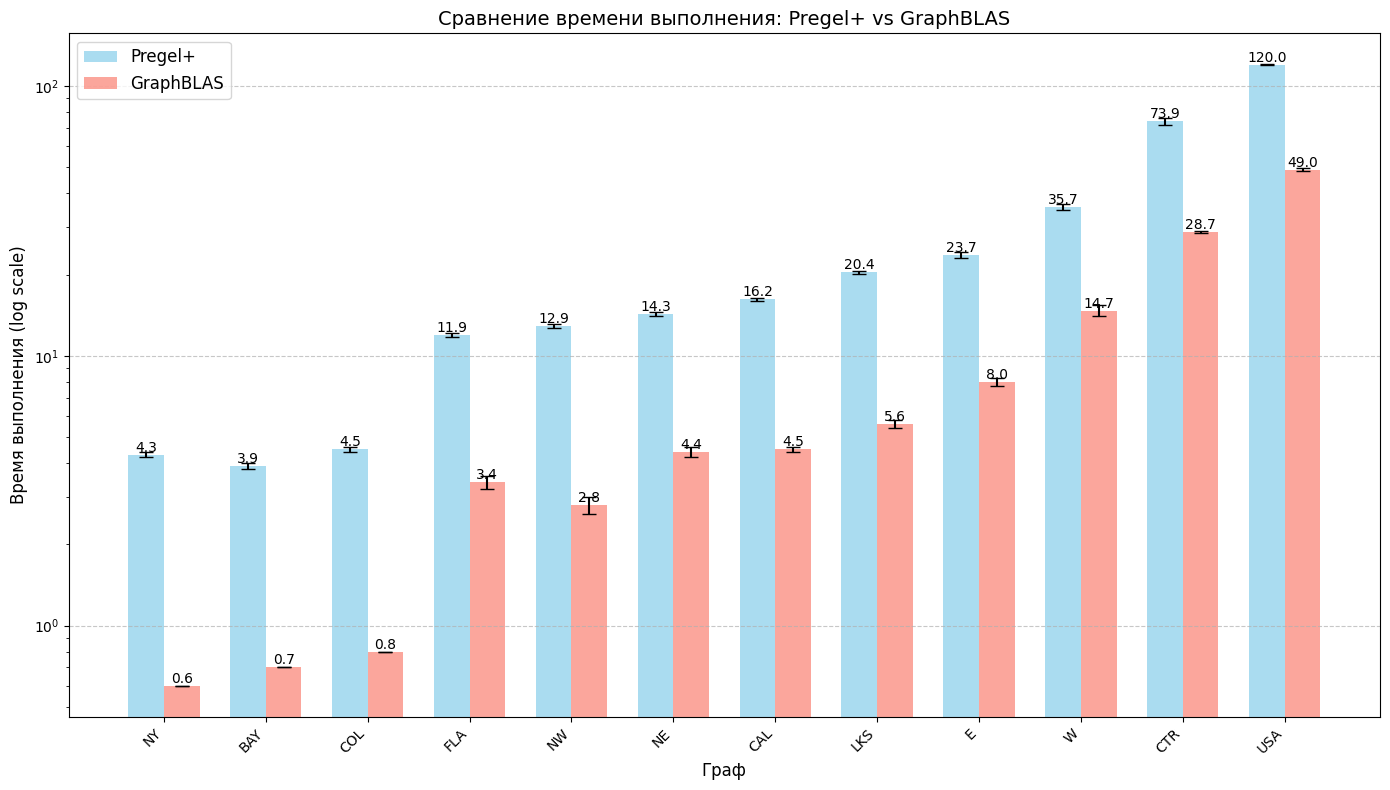

In [ ]:
def plot_comparison(results):
    plt.figure(figsize=(14, 8))

    x = np.arange(len(results["prefix"]))
    width = 0.35

    pregel_bars = plt.bar(
        x - width / 2,
        results["pregel_mean"],
        width,
        yerr=results["pregel_ci"],
        label="Pregel+",
        color="skyblue",
        alpha=0.7,
        capsize=5,
    )

    blas_bars = plt.bar(
        x + width / 2,
        results["blas_mean"],
        width,
        yerr=results["blas_ci"],
        label="GraphBLAS",
        color="salmon",
        alpha=0.7,
        capsize=5,
    )

    plt.xlabel("Граф", fontsize=12)
    plt.ylabel("Среднее время выполнения (сек)", fontsize=12)
    plt.title("Сравнение времени выполнения: Pregel+ vs GraphBLAS", fontsize=14)
    plt.xticks(x, results["prefix"], rotation=45, ha="right")

    for bar in pregel_bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    for bar in blas_bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    if (
        max(results["pregel_mean"] + results["blas_mean"])
        / min(results["pregel_mean"] + results["blas_mean"])
        > 100
    ):
        plt.yscale("log")
        plt.ylabel("Время выполнения (log scale)")

    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


def analyze_performance(
    pregel_results_base_path, blas_results_base_path, confidence=0.99
):
    results = {
        "prefix": [],
        "pregel_mean": [],
        "blas_mean": [],
        "pregel_ci": [],
        "blas_ci": [],
    }

    for prefix in PREFIXES:
        pregel_time_file = os.path.join(
            pregel_results_base_path, f"{prefix}_results", f"{prefix}_time_pregel.txt"
        )
        blas_time_file = os.path.join(
            blas_results_base_path, f"{prefix}_results", f"{prefix}_time_blas.txt"
        )

        try:
            with open(pregel_time_file, "r") as f:
                pregel_times = np.array(
                    [float(line.strip()) for line in f.readlines() if line.strip()]
                )

            with open(blas_time_file, "r") as f:
                blas_times = np.array(
                    [float(line.strip()) for line in f.readlines() if line.strip()]
                )

        except FileNotFoundError as e:
            print(f"Ошибка при чтении файлов для префикса {prefix}: {e}")
            continue

        pregel_mean = round(np.mean(pregel_times), 1)
        blas_mean = round(np.mean(blas_times), 1)
        pregel_std = np.std(pregel_times, ddof=1)
        blas_std = np.std(blas_times, ddof=1)

        n = len(pregel_times)
        pregel_se = pregel_std / np.sqrt(n)
        blas_se = blas_std / np.sqrt(n)

        t_value = stats.t.ppf((1 + confidence) / 2, n - 1)

        pregel_ci = round(t_value * pregel_se, 1)
        blas_ci = round(t_value * blas_se, 1)

        results["prefix"].append(prefix)
        results["pregel_mean"].append(pregel_mean)
        results["blas_mean"].append(blas_mean)
        results["pregel_ci"].append(pregel_ci)
        results["blas_ci"].append(blas_ci)

    print("\n" + "=" * 80)
    print("Сравнение времени выполнения: Pregel+ vs GraphBLAS")
    print(
        "{:<10} | {:<20} | {:<20}".format(
            "Name", "Pregel+ (mean ± ci)", "GraphBLAS (mean ± ci)"
        )
    )
    print("-" * 60)
    for i in range(len(results["prefix"])):
        pregel_str = f"{results['pregel_mean'][i]:.1f} ± {results['pregel_ci'][i]:.1f}"
        blas_str = f"{results['blas_mean'][i]:.1f} ± {results['blas_ci'][i]:.1f}"
        print(
            "{:<10} | {:<20} | {:<20}".format(
                results["prefix"][i], pregel_str, blas_str
            )
        )

    plot_comparison(results)


analyze_performance(pregel_results_abs_path, blas_results_abs_path, confidence=0.95)


Процент времени, потраченного на обмен сообщениями в Pregel+
Name       | MPI% (mean ± ci)    
------------------------------------------------------------
NY         | 48.5 ± 0.4          
BAY        | 49.5 ± 0.4          
COL        | 50.1 ± 0.4          
FLA        | 54.5 ± 0.4          
NW         | 55.6 ± 0.4          
NE         | 56.7 ± 0.5          
CAL        | 58.2 ± 0.5          
LKS        | 60.4 ± 0.5          
E          | 60.6 ± 0.7          
W          | 62.4 ± 0.8          
CTR        | 63.8 ± 0.8          
USA        | 63.5 ± 0.8          


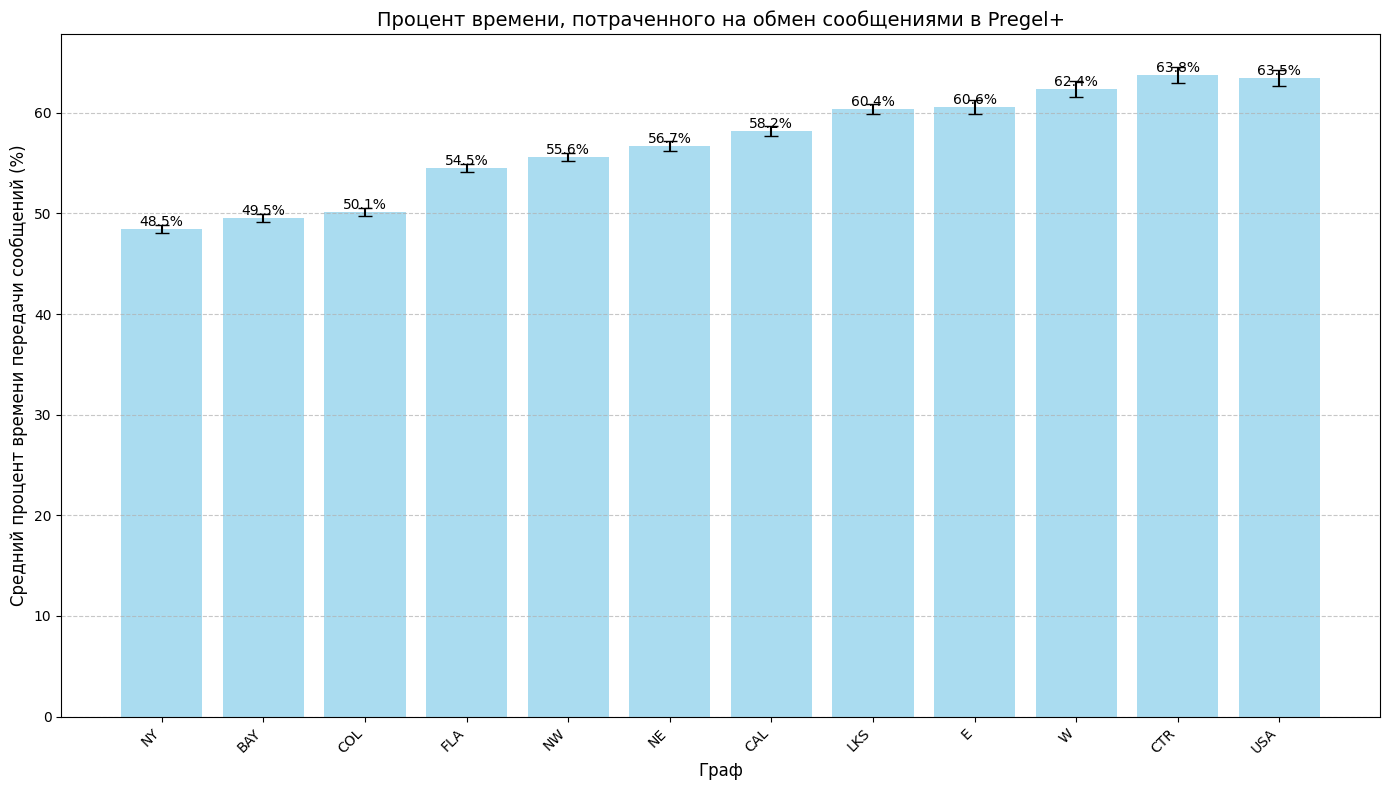

In [78]:
def analyze_mpi_performance(pregel_results_base_path, confidence=0.95):
    results = {
        "prefix": [],
        "mpi_percent_mean": [],
        "mpi_percent_ci": [],
    }

    for prefix in PREFIXES:
        mpi_percentages = []
        prefix_dir = os.path.join(pregel_results_base_path, f"{prefix}_results")
        try:
            run_files = [f for f in os.listdir(prefix_dir) if f.startswith("run.14.")]
        except FileNotFoundError:
            print(f"Warning: Directory not found for prefix {prefix}")
            continue

        if not run_files:
            print(f"Warning: No run.14.* files found for prefix {prefix}")
            continue

        for run_file in run_files:
            run_file_path = os.path.join(prefix_dir, run_file)

            try:
                try:
                    with open(run_file_path, "r", encoding="utf-8") as f:
                        content = f.read()
                except UnicodeDecodeError:
                    with open(run_file_path, "r", encoding="latin-1") as f:
                        content = f.read()

                for line in content.split("\n"):
                    if line.strip().startswith("*"):
                        parts = line.split()
                        if len(parts) >= 4:
                            mpi_percent = float(parts[3].replace(",", "."))
                            mpi_percentages.append(mpi_percent)
                        break
            except Exception as e:
                print(f"Error processing file {run_file_path}: {str(e)}")
                continue

        if not mpi_percentages:
            print(f"Warning: No valid MPI data found for prefix {prefix}")
            continue

        mpi_percentages = np.array(mpi_percentages)
        mean = round(np.mean(mpi_percentages), 1)
        std = np.std(mpi_percentages, ddof=1)
        n = len(mpi_percentages)
        se = std / np.sqrt(n)
        t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
        ci = round(t_value * se, 1)

        results["prefix"].append(prefix)
        results["mpi_percent_mean"].append(mean)
        results["mpi_percent_ci"].append(ci)

    print("\n" + "=" * 80)
    print("Процент времени, потраченного на обмен сообщениями в Pregel+")
    print("{:<10} | {:<20}".format("Name", "MPI% (mean ± ci)"))
    print("-" * 60)
    for i in range(len(results["prefix"])):
        print(
            "{:<10} | {:<20}".format(
                results["prefix"][i],
                f"{results['mpi_percent_mean'][i]:.1f} ± {results['mpi_percent_ci'][i]:.1f}",
            )
        )

    plot_mpi_performance(results)


def plot_mpi_performance(results):
    plt.figure(figsize=(14, 8))

    x = np.arange(len(results["prefix"]))

    bars = plt.bar(
        x,
        results["mpi_percent_mean"],
        yerr=results["mpi_percent_ci"],
        color="skyblue",
        alpha=0.7,
        capsize=5,
    )

    plt.xlabel("Граф", fontsize=12)
    plt.ylabel("Средний процент времени передачи сообщений (%)", fontsize=12)
    plt.title(
        "Процент времени, потраченного на обмен сообщениями в Pregel+", fontsize=14
    )
    plt.xticks(x, results["prefix"], rotation=45, ha="right")

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


analyze_mpi_performance(pregel_results_abs_path, confidence=0.95)